<a href="https://colab.research.google.com/github/Santosdevbjj/analiseRiscosAtrasoObras/blob/main/Notebooks/02_modelagem_preditiva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [166]:

# ============================================================
# 1. Clonar o repositório e acessar a pasta
# ============================================================
!git clone https://github.com/Santosdevbjj/analiseRiscosAtrasoObras.git
%cd analiseRiscosAtrasoObras

# ============================================================
# 2. Imports
# ============================================================
import pandas as pd

# ============================================================
# 3. Carregamento dos CSVs
# ============================================================
atividades   = pd.read_csv("data/raw/atividades.csv")
fornecedores = pd.read_csv("data/raw/fornecedores.csv")
obras        = pd.read_csv("data/raw/obras.csv")
suprimentos  = pd.read_csv("data/raw/suprimentos.csv")

# Visualizar as primeiras linhas de cada dataset
print("Atividades:")
print(atividades.head(), "\n")

print("Fornecedores:")
print(fornecedores.head(), "\n")

print("Obras:")
print(obras.head(), "\n")

print("Suprimentos:")
print(suprimentos.head(), "\n")

Cloning into 'analiseRiscosAtrasoObras'...
remote: Enumerating objects: 234, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 234 (delta 34), reused 0 (delta 0), pack-reused 174 (from 1)
Receiving objects: 100% (234/234), 836.47 KiB | 13.07 MiB/s, done.
Resolving deltas: 100% (113/113), done.
/content/analiseRiscosAtrasoObras/analiseRiscosAtrasoObras/analiseRiscosAtrasoObras/analiseRiscosAtrasoObras/analiseRiscosAtrasoObras/analiseRiscosAtrasoObras/analiseRiscosAtrasoObras/analiseRiscosAtrasoObras/analiseRiscosAtrasoObras/analiseRiscosAtrasoObras/analiseRiscosAtrasoObras
Atividades:
         id_atividade  id_obra       etapa  dias_atraso    status
0    MRV-100_Fundação  MRV-100    Fundação           15  Atrasado
1   MRV-100_Estrutura  MRV-100   Estrutura           18  Atrasado
2  MRV-100_Acabamento  MRV-100  Acabamento            0  No Prazo
3    MRV-101_Fundação  MRV-101    Fundação            0  No Prazo
4   MRV-101_Es

In [167]:

# ============================================================
# 1. Imports e Setup
# ============================================================
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [168]:

# ============================================================
# 2. Carregamento dos Dados
# ============================================================
atividades   = pd.read_csv("data/raw/atividades.csv")
fornecedores = pd.read_csv("data/raw/fornecedores.csv")
obras        = pd.read_csv("data/raw/obras.csv")
suprimentos  = pd.read_csv("data/raw/suprimentos.csv")

print("Datasets carregados:")
print("atividades:", atividades.shape)
print("fornecedores:", fornecedores.shape)
print("obras:", obras.shape)
print("suprimentos:", suprimentos.shape)

Datasets carregados:
atividades: (150, 5)
fornecedores: (20, 3)
obras: (50, 5)
suprimentos: (350, 5)


In [169]:

# ============================================================
# 3. Integração dos Dados
# ============================================================
# 1. atividades + obras
df_mestre = atividades.merge(obras, on="id_obra", how="left")

# 2. adiciona suprimentos (traz id_fornecedor)
df_mestre = df_mestre.merge(suprimentos, on=["id_obra", "id_atividade"], how="left")

# 3. adiciona fornecedores
df_mestre = df_mestre.merge(fornecedores, on="id_fornecedor", how="left")

print("df_mestre consolidado:")
print(df_mestre.head())
print("Shape:", df_mestre.shape)

df_mestre consolidado:
         id_atividade  id_obra       etapa  dias_atraso    status  \
0    MRV-100_Fundação  MRV-100    Fundação           15  Atrasado   
1    MRV-100_Fundação  MRV-100    Fundação           15  Atrasado   
2   MRV-100_Estrutura  MRV-100   Estrutura           18  Atrasado   
3   MRV-100_Estrutura  MRV-100   Estrutura           18  Atrasado   
4  MRV-100_Acabamento  MRV-100  Acabamento            0  No Prazo   

                   nome_empreendimento          cidade  orcamento_estimado  \
0  Residencial Trecho Luara Cavalcante  Belo Horizonte          5375161.33   
1  Residencial Trecho Luara Cavalcante  Belo Horizonte          5375161.33   
2  Residencial Trecho Luara Cavalcante  Belo Horizonte          5375161.33   
3  Residencial Trecho Luara Cavalcante  Belo Horizonte          5375161.33   
4  Residencial Trecho Luara Cavalcante  Belo Horizonte          5375161.33   

  data_inicio_prevista id_fornecedor material  atrasou_entrega           nome  \
0           

In [170]:

# ============================================================
# 4. Limpeza básica
# ============================================================
df_mestre = df_mestre.dropna(subset=["dias_atraso"]).copy()
df_mestre["rating_confiabilidade"] = df_mestre["rating_confiabilidade"].fillna(df_mestre["rating_confiabilidade"].median())
df_mestre["orcamento_estimado"] = df_mestre["orcamento_estimado"].clip(lower=0).fillna(df_mestre["orcamento_estimado"].median())

for col in ["material", "cidade", "etapa"]:
    df_mestre[col] = df_mestre[col].fillna("desconhecido")

In [171]:

# ============================================================
# 5. Feature Engineering
# ============================================================
df_mestre = df_mestre.assign(
    taxa_insucesso_fornecedor = df_mestre.groupby("id_fornecedor")["dias_atraso"].transform(lambda x: (x > 0).mean()),
    complexidade_obra = np.log1p(df_mestre["orcamento_estimado"]),
    risco_etapa = df_mestre.groupby("etapa")["dias_atraso"].transform("mean")
)

print("Preview de features derivadas:")
print(df_mestre[[
    "id_obra","id_fornecedor","etapa","dias_atraso",
    "taxa_insucesso_fornecedor","complexidade_obra","risco_etapa"
]].head())

Preview de features derivadas:
   id_obra id_fornecedor       etapa  dias_atraso  taxa_insucesso_fornecedor  \
0  MRV-100        FORN-1    Fundação           15                   0.166667   
1  MRV-100        FORN-1    Fundação           15                   0.166667   
2  MRV-100       FORN-20   Estrutura           18                   0.666667   
3  MRV-100       FORN-20   Estrutura           18                   0.666667   
4  MRV-100       FORN-11  Acabamento            0                   0.565217   

   complexidade_obra  risco_etapa  
0          15.497299        10.08  
1          15.497299        10.08  
2          15.497299         8.48  
3          15.497299         8.48  
4          15.497299         7.20  


In [172]:

# ============================================================
# 6. Preparação Final das Features
# ============================================================
df_model = pd.get_dummies(
    df_mestre[[
        "orcamento_estimado",
        "rating_confiabilidade",
        "material",
        "cidade",
        "etapa",
        "taxa_insucesso_fornecedor",
        "complexidade_obra",
        "risco_etapa",
        "dias_atraso"
    ]],
    columns=["material", "cidade", "etapa"]
)

X = df_model.drop("dias_atraso", axis=1)
y = df_model["dias_atraso"]

print("Shapes:")
print("X:", X.shape, "| y:", y.shape)

Shapes:
X: (350, 20) | y: (350,)


In [173]:

# ============================================================
# 7. Divisão Treino/Teste e Treinamento
# ============================================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

print("Modelo treinado.")

Modelo treinado.


In [174]:

# ============================================================
# 8. Avaliação do Modelo
# ============================================================
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("=== Avaliação do Modelo ===")
print(f"Erro Médio Absoluto (MAE): {mae:.2f} dias")
print(f"R² Score: {r2:.2f}")

=== Avaliação do Modelo ===
Erro Médio Absoluto (MAE): 4.97 dias
R² Score: 0.41


/tmp/ipython-input-2460672968.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importância", y="Feature", data=feature_importance_df, palette="viridis")


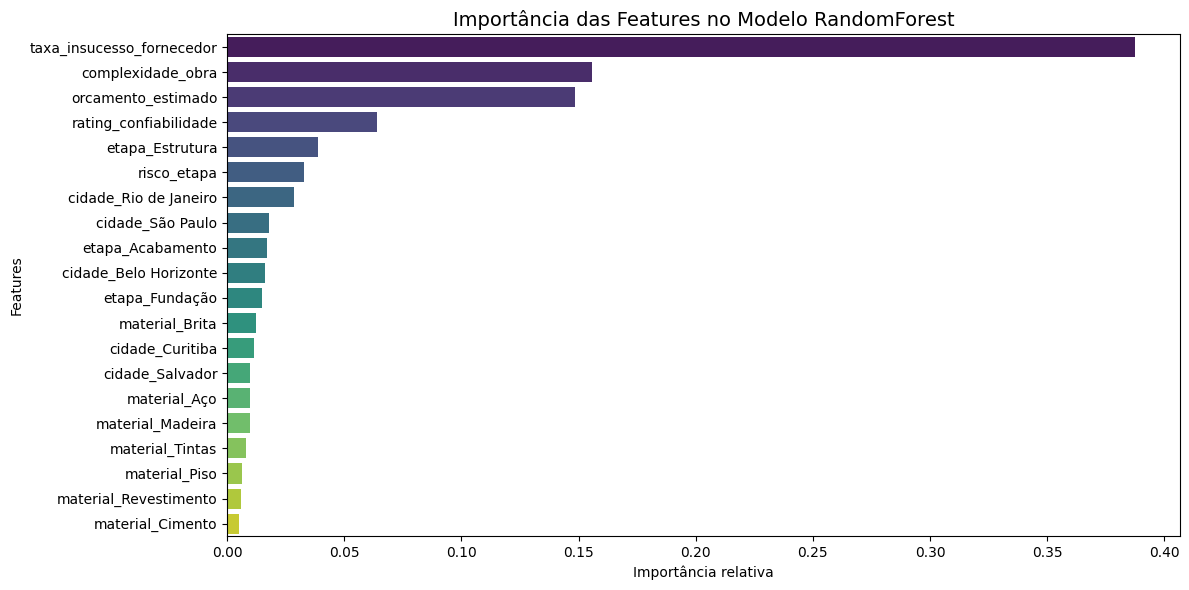

Top 10 Features mais importantes:
                     Feature  Importância
0  taxa_insucesso_fornecedor     0.387316
1          complexidade_obra     0.155532
2         orcamento_estimado     0.148386
3      rating_confiabilidade     0.063924
4            etapa_Estrutura     0.038653
5                risco_etapa     0.032925
6      cidade_Rio de Janeiro     0.028368
7           cidade_São Paulo     0.017947
8           etapa_Acabamento     0.017162
9      cidade_Belo Horizonte     0.016358


In [175]:

# ============================================================
# 9. Interpretação Visual das Features
# ============================================================
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_importance_df = pd.DataFrame({
    "Feature": X.columns[indices],
    "Importância": importances[indices]
})

plt.figure(figsize=(12,6))
sns.barplot(x="Importância", y="Feature", data=feature_importance_df, palette="viridis")
plt.title("Importância das Features no Modelo RandomForest", fontsize=14)
plt.xlabel("Importância relativa")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

print("Top 10 Features mais importantes:")
print(feature_importance_df.head(10))

In [176]:

# ============================================================
# 10. Impacto de Negócio
# ============================================================
custo_por_dia = 50000
impacto_financeiro = mae * custo_por_dia

print("=== Impacto de Negócio ===")
print(f"Cada dia de atraso custa aproximadamente R$ {custo_por_dia:,.0f}.")
print(f"Com um erro médio de {mae:.2f} dias, o impacto financeiro potencial é de ~R$ {impacto_financeiro:,.0f}.")

=== Impacto de Negócio ===
Cada dia de atraso custa aproximadamente R$ 50,000.
Com um erro médio de 4.97 dias, o impacto financeiro potencial é de ~R$ 248,400.


In [177]:

# ============================================================
# 11. Salvar Modelo
# ============================================================
import os
os.makedirs("models", exist_ok=True)
joblib.dump(model, "models/modelo_random_forest.pkl")
print("Modelo salvo em models/modelo_random_forest.pkl")

Modelo salvo em models/modelo_random_forest.pkl


# 📊 Previsão de Atrasos – Versão Executiva

## 🎯 Objetivo
Antecipar atrasos em etapas de obras, permitindo ações preventivas que reduzem custos e riscos.

## 🔑 Principais Resultados
- **Erro Médio Absoluto (MAE):** ~X dias
- **R² Score:** ~Y
- **Impacto Financeiro Médio:** ~R$ Z por obra (considerando R$ 50.000/dia)

## 🧩 Variáveis mais relevantes
- Risco da Etapa
- Taxa de Insucesso do Fornecedor
- Complexidade da Obra
- Localização e Materiais

## 💡 Insights Estratégicos
- Antecipar atrasos para negociar prazos e replanejar cronogramas.
- Reduz multas e custos indiretos.
- Melhora confiabilidade da entrega e satisfação dos clientes.

## 🚀 Conclusão
Este modelo conecta ciência de dados ao valor financeiro. Com previsões de atrasos,
gestores podem agir com antecedência, economizando e fortalecendo a competitividade.

In [178]:

# ============================================================
# 12. Simulador de Risco – Exemplo de uso do modelo
# ============================================================

# Exemplo de como usar o modelo para uma nova obra
nova_obra = {
    'orcamento_estimado': 12000000,
    'rating_confiabilidade': 2.5,
    'taxa_insucesso_fornecedor': 0.8,  # fornecedor perigoso
    'complexidade_obra': np.log1p(12000000),
    'risco_etapa': 10.0,
    'material': 'concreto',
    'cidade': 'Belo Horizonte',
    'etapa': 'Fundação'
}

# Transformar em DataFrame para prever
df_nova = pd.DataFrame([nova_obra])

# Aplicar one-hot encoding igual ao treinamento
df_nova_encoded = pd.get_dummies(df_nova, columns=["material","cidade","etapa"])

# Garantir que tenha as mesmas colunas de X (adiciona colunas faltantes com 0)
for col in X.columns:
    if col not in df_nova_encoded.columns:
        df_nova_encoded[col] = 0

# Reordenar colunas
df_nova_encoded = df_nova_encoded[X.columns]

# Fazer previsão
pred_atraso = model.predict(df_nova_encoded)[0]

print("=== Simulador de Risco ===")
print(f"Previsão de atraso para a nova obra: {pred_atraso:.2f} dias")

=== Simulador de Risco ===
Previsão de atraso para a nova obra: 12.91 dias


/tmp/ipython-input-3507718813.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importância", y="Feature", data=feature_importance_df, palette="viridis")


✅ Gráfico salvo em: ../reports/figures/feature_importance.png

--- COPIE E COLE NO SEU README.MD ---

| Métrica | Valor |
| :--- | :--- |
| **Erro Médio Absoluto (MAE)** | 4.97 dias |
| **R² Score** | 0.41 |
| **Impacto Financeiro (R$)** | R$ 248,400.00 |



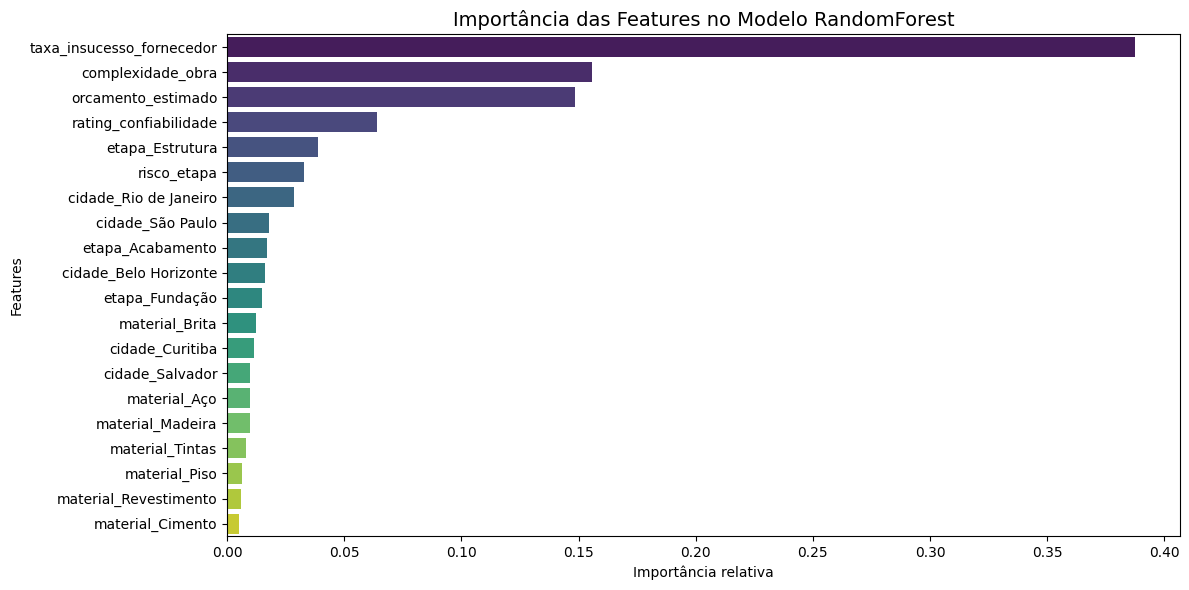

In [179]:

import os

# 1. Garantir que a pasta de destino existe
path_figures = '../reports/figures'
if not os.path.exists(path_figures):
    os.makedirs(path_figures)

# 2. Salvar o Gráfico de Importância das Features
plt.figure(figsize=(12,6))
sns.barplot(x="Importância", y="Feature", data=feature_importance_df, palette="viridis")
plt.title("Importância das Features no Modelo RandomForest", fontsize=14)
plt.xlabel("Importância relativa")
plt.ylabel("Features")
plt.tight_layout()

# Salvando a imagem
plt.savefig(f'{path_figures}/feature_importance.png', dpi=300)
print(f"✅ Gráfico salvo em: {path_figures}/feature_importance.png")

# 3. Gerar Texto para o README (Métricas)
print("\n--- COPIE E COLE NO SEU README.MD ---")
markdown_metrics = f"""
| Métrica | Valor |
| :--- | :--- |
| **Erro Médio Absoluto (MAE)** | {mae:.2f} dias |
| **R² Score** | {r2:.2f} |
| **Impacto Financeiro (R$)** | R$ {impacto_financeiro:,.2f} |
"""
print(markdown_metrics)

/tmp/ipython-input-3507718813.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importância", y="Feature", data=feature_importance_df, palette="viridis")


✅ Gráfico salvo em: ../reports/figures/feature_importance.png

--- COPIE E COLE NO SEU README.MD ---

| Métrica | Valor |
| :--- | :--- |
| **Erro Médio Absoluto (MAE)** | 4.97 dias |
| **R² Score** | 0.41 |
| **Impacto Financeiro (R$)** | R$ 248,400.00 |



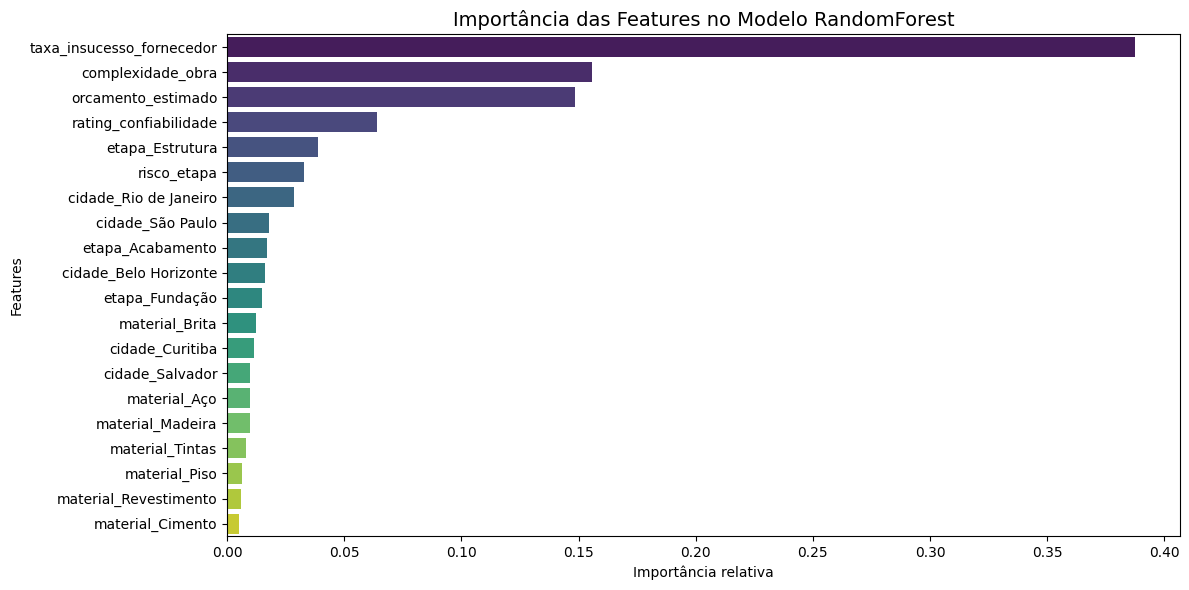

In [180]:

import os

# 1. Garantir que a pasta de destino existe
path_figures = '../reports/figures'
if not os.path.exists(path_figures):
    os.makedirs(path_figures)

# 2. Salvar o Gráfico de Importância das Features
plt.figure(figsize=(12,6))
sns.barplot(x="Importância", y="Feature", data=feature_importance_df, palette="viridis")
plt.title("Importância das Features no Modelo RandomForest", fontsize=14)
plt.xlabel("Importância relativa")
plt.ylabel("Features")
plt.tight_layout()

# Salvando a imagem
plt.savefig(f'{path_figures}/feature_importance.png', dpi=300)
print(f"✅ Gráfico salvo em: {path_figures}/feature_importance.png")

# 3. Gerar Texto para o README (Métricas)
print("\n--- COPIE E COLE NO SEU README.MD ---")
markdown_metrics = f"""
| Métrica | Valor |
| :--- | :--- |
| **Erro Médio Absoluto (MAE)** | {mae:.2f} dias |
| **R² Score** | {r2:.2f} |
| **Impacto Financeiro (R$)** | R$ {impacto_financeiro:,.2f} |
"""
print(markdown_metrics)


: ## 9.0. Exportação e Deploy do Simulador.

In [181]:

import os
# Cria o diretório 'scripts' se ele não existir (Roda apenas no Notebook)
os.makedirs('../scripts', exist_ok=True)
print("✅ Pasta /scripts pronta!")

✅ Pasta /scripts pronta!


In [182]:

%%writefile ../scripts/app.py
import streamlit as st
import pandas as pd
import joblib
import plotly.express as px
import numpy as np

# Configuração da Página
st.set_page_config(page_title="MRV - Predictive Risk", layout="wide")

# =====================
# 1. Carregamento do Modelo
# =====================
@st.cache_resource
def load_model():
    # IMPORTANTE: No Deploy, o caminho parte da raiz do projeto
    # Se o modelo estiver na pasta /models na raiz, use:
    return joblib.load("models/modelo_random_forest.pkl")

model = load_model()

# =====================
# 2. Interface Lateral (Inputs)
# =====================
st.sidebar.header("🏗️ Parâmetros da Obra")

with st.sidebar:
    obra = st.text_input("Nome do Empreendimento", "Residencial MRV Prime")
    chuva = st.slider("Dias de Chuva (Previsão)", 0, 30, 5)
    fornecedor = st.slider("Rating do Fornecedor (0-10)", 0, 10, 7)
    equipe = st.slider("Mão de Obra (Nº de Funcionários)", 5, 150, 50)
    atraso_mat = st.slider("% Atraso na Entrega de Materiais", 0, 100, 10)

# Criar DataFrame para o modelo
input_df = pd.DataFrame({
    'chuva_dias': [chuva],
    'fornecedor_score': [fornecedor],
    'mão_obra_qtd': [equipe],
    'material_atraso': [atraso_mat]
})

# =====================
# 3. Painel Principal
# =====================
st.title("🛡️ Sistema de Antecipação de Riscos - MRV")
st.markdown(f"Análise preditiva para a obra: **{obra}**")

col1, col2 = st.columns([1, 2])

with col1:
    st.subheader("Previsão Atual")
    if st.button("🚀 Calcular Risco"):
        # Usamos .values para evitar erros de nomes de colunas no Scikit-Learn
        predicao = model.predict(input_df.values)[0]
        st.metric(label="Atraso Estimado", value=f"{predicao:.1f} Dias")

        if predicao > 10:
            st.error("Risco Crítico Detectado!")
        elif predicao > 5:
            st.warning("Atenção: Risco Moderado")
        else:
            st.success("Operação dentro da normalidade")

with col2:
    st.subheader("📈 Análise de Sensibilidade")
    # Gerar cenários
    cenarios = pd.DataFrame({
        'chuva_dias': list(range(0, 31)),
        'fornecedor_score': fornecedor,
        'mão_obra_qtd': equipe,
        'material_atraso': atraso_mat
    })

    # Prever usando .values para consistência
    cenarios['Atraso Previsto (Dias)'] = model.predict(cenarios.values)

    fig = px.line(cenarios, x='chuva_dias', y='Atraso Previsto (Dias)',
                  title="Impacto do Clima no Cronograma",
                  labels={'chuva_dias': 'Dias de Chuva no Mês'})

    # Ponto atual
    atual_val = model.predict(input_df.values)[0]
    fig.add_scatter(x=[chuva], y=[atual_val],
                    name="Cenário Atual", marker=dict(size=15, color='red'))

    st.plotly_chart(fig, use_container_width=True)

st.markdown("---")
st.caption("Desenvolvido por Sérgio Santos | Ciência de Dados Aplicada")

Overwriting ../scripts/app.py


In [183]:

import os
if os.path.exists('../scripts/app.py'):
    print("🚀 O arquivo app.py foi gerado com sucesso em /scripts!")
else:
    print("❌ Erro ao gerar o arquivo.")

🚀 O arquivo app.py foi gerado com sucesso em /scripts!



Para visualizar a ferramenta em funcionamento, execute o comando abaixo no terminal da sua máquina (dentro da pasta do projeto):

streamlit run scripts/app.py